---
# Model S - From Scratch, Data Augmentation, Adam
> 64 Batch size  
> Data augmentation (horizontal flip)  
> Adaptive Moment Estimation (Adam) optimizer  
> 0.001 Initial Learning rate  
> 3 x 3 Convolutional kernel size  
> 4 x 4 x 128 Tensor before flatten  
> 40 Epochs with early stopping  
> Callback to control learning rate, best model saving based on validation accuracy and early stopping  
> Batch Normalization after each convolutional layer  
> L2 regularization 0.0001 on the 32, 64 and 128 convolutional layers  
> L2 regularization 0.01 on the 256 and 64 dense layer  
> Dropout of 0.5 on the 256 dense layer and 0.25 on the 64 dense layer  

---
#### Imports and Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import callbacks, layers, optimizers, models
from keras import regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,accuracy_score, precision_score, recall_score, f1_score

TensorFlow version: 2.12.0


---
#### Group Datasets

In [2]:
train_dirs = ['../data/train1', '../data/train3', '../data/train4', '../data/train5']
validation_dir = '../data/train2'
test_dir = '../data/test'

> ((2221985 + 2221986) % 5) + 1 = 2  
> Validation set: train2.  

---
####  Count Images in Categories

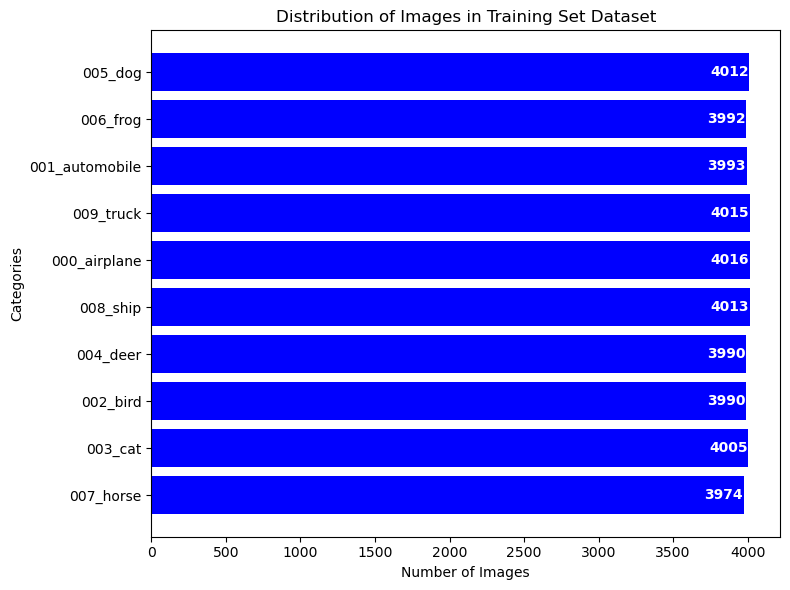

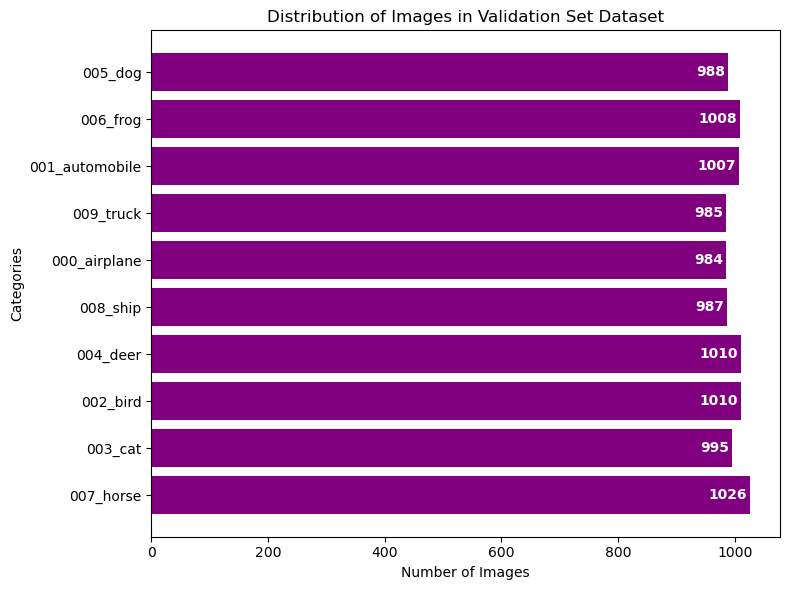

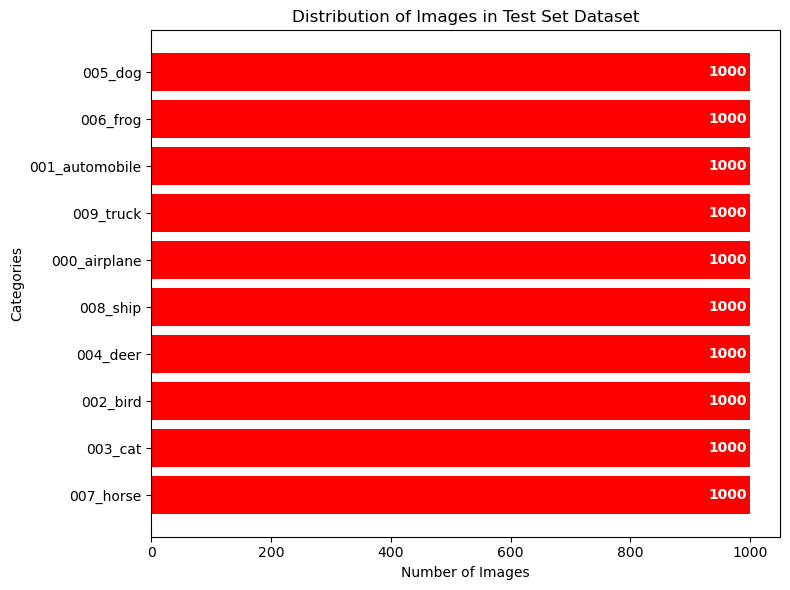

In [3]:
def count_images_in_categories(directory):
    categories = os.listdir(directory)
    category_counts = {}
    for category in categories:
        category_counts[category] = len(os.listdir(os.path.join(directory, category)))
    return category_counts

train_counts_each_dir = [count_images_in_categories(train_dir) for train_dir in train_dirs]
validation_counts = count_images_in_categories(validation_dir)
test_counts = count_images_in_categories(test_dir)
train_counts = {category: sum([count.get(category, 0) for count in train_counts_each_dir]) for category in train_counts_each_dir[0]}

def plot_statistics(dataset_name, category_counts, color):
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    num_categories = len(categories)
    plt.figure(figsize=(8, 6))
    bars = plt.barh(range(num_categories), counts, color=color, alpha=1)

    for bar, count in zip(bars, counts):
        plt.text(bar.get_width() - 5, bar.get_y() + bar.get_height()/2, str(count), va='center', ha='right', color='white', fontweight='bold')
        
    plt.ylabel('Categories')
    plt.xlabel('Number of Images')
    plt.yticks(range(num_categories), categories)
    plt.title(f'Distribution of Images in {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()

plot_statistics('Training Set', train_counts, 'blue')
plot_statistics('Validation Set', validation_counts, 'purple')
plot_statistics('Test Set', test_counts, 'red')

> We count the images of each category in each folder and plot the distribution.  
> We see that there are minor deviations the number of samples of each category in the train dataset and a bit more in the validation dataset. 

---
#### Create Datasets

In [4]:
IMG_SIZE = 32
BATCH_SIZE = 32
NUM_CLASSES = len(train_counts)

train_datasets = [image_dataset_from_directory(directory, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE) for directory in train_dirs]

train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

class_names = train_datasets[0].class_names

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


> We define the image size of 32 x 32 x 3 and batch size of 64 and create an array with the label's names.  
> We create the train dataset by concatenating them, we shuffle the samples before each epoch and prefetch them to memory.  
> We do the same for the validation and test dataset except shuffling which is unnecessary.

---
#### Dataset Analysis

In [5]:
for data_batch, labels_batch in train_dataset.take(1):
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)

data batch shape: (32, 32, 32, 3)
labels batch shape: (32,)


> We have batches of 64 images, 32 by 32 pixels with 3 channels (RGB).  
> We also have batches of 64 labels, one for each image.  

---
#### Data Augmentation

In [6]:
data_augmentation = keras.Sequential(
    [
        # keras.layers.RandomCrop(height=32, width=32), # This layer is commented out because it is not compatible with the current model architecture.
        keras.layers.RandomFlip("horizontal"),
        # keras.layers.RandomTranslation(0.1, 0.1), # This layer is commented out because it didn't improve the model performance.
        # keras.layers.RandomRotation(0.1), # This layer is commented out because it didn't improve the model performance.
        # keras.layers.RandomZoom(0.1), # This layer is commented out because it didn't improve the model performance.
        keras.layers.RandomContrast(0.1),
        keras.layers.RandomBrightness(0.1),
    ]
)

> We define a data augmentation pipeline to apply to the images.  
> The pipeline:  
> Applies horizontal flipping to a random 50% of the images that go through it.  

> The following techniques were tested but the model didn't perform well:  
> Randomly translates the input images along the width and height by 10%.  
> Randomly adjusts the contrast of the input images by -+ 10%.  
> Randomly adjusts the brightness of the input images by -+ 10%.  
> Rotates the input images by a random value in the range [–10%, +10%] (these are fractions of a full circle—in degrees, the range would be [–36 degrees, +36 degrees]). 

---
#### Augmented Dataset Visualization

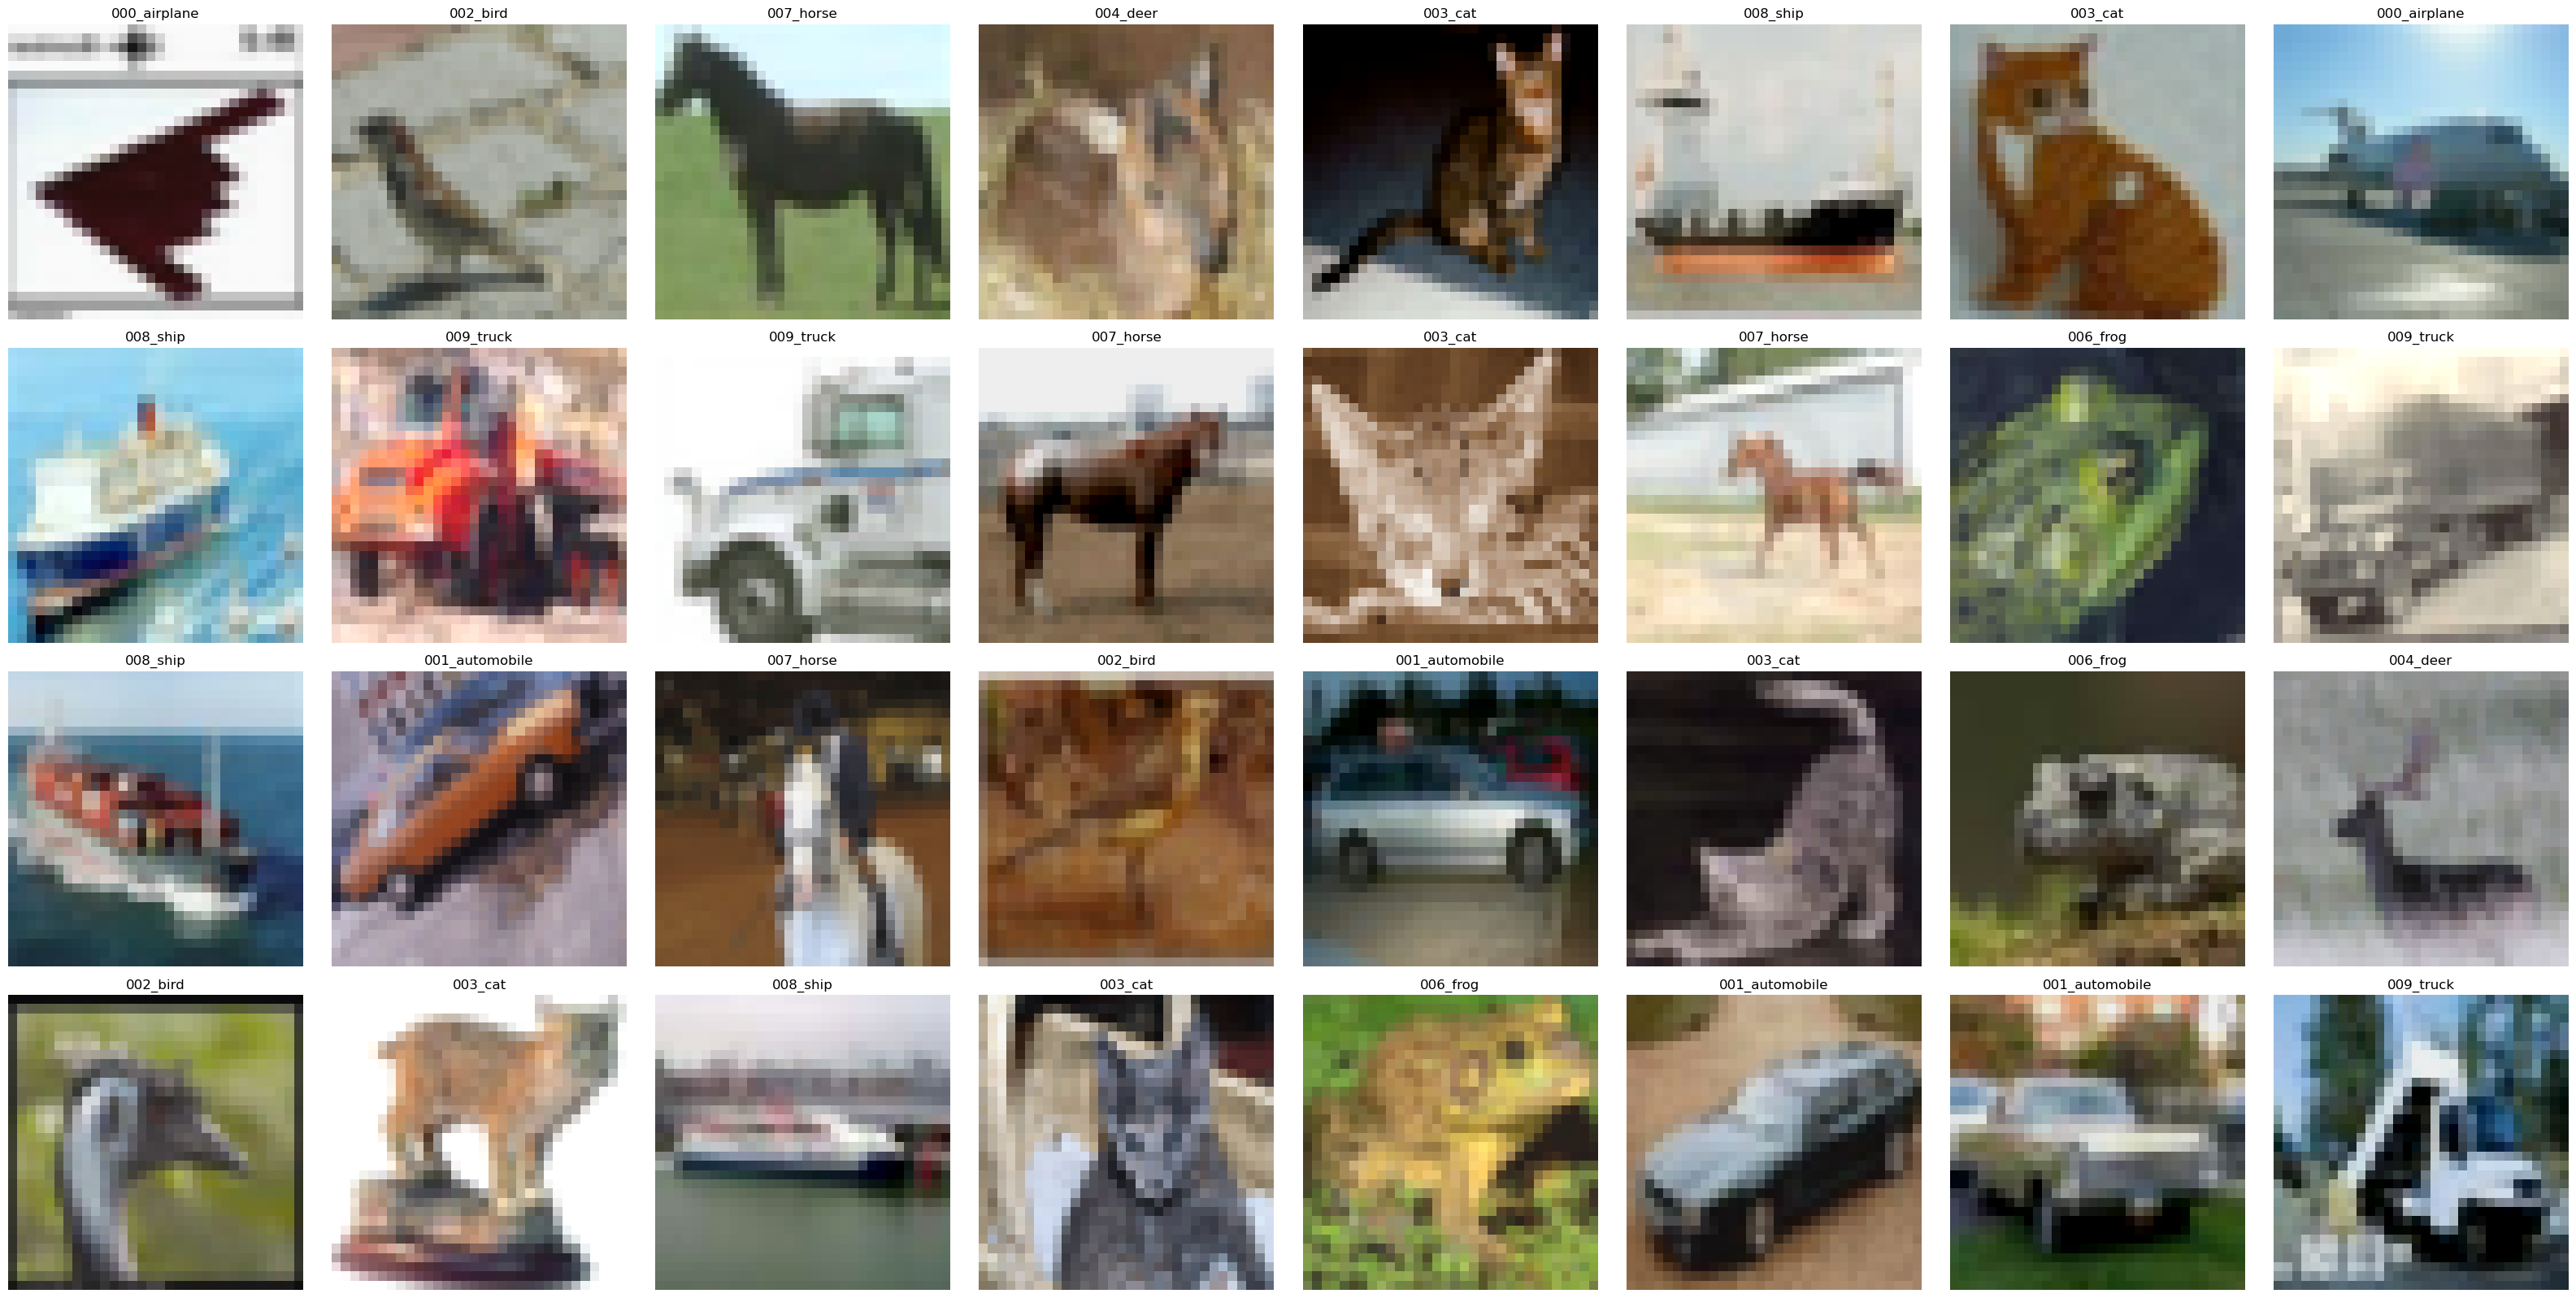

In [7]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(32, 32))
    for i in range(len(images)):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
        plt.tight_layout()
    plt.show()

> We print a random batch of augmented images from the train dataset along with their respective labels.  
> We see that the images are of different categories and are of low resolution, but we have slightly more variety in the images.

---
#### Model Arquitecture

In [8]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, kernel_regularizer=regularizers.L2(0.0001), activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=32, kernel_size=3, kernel_regularizer=regularizers.L2(0.0001), activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, kernel_regularizer=regularizers.L2(0.0001), activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=64, kernel_size=3, kernel_regularizer=regularizers.L2(0.0001), activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.L2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.L2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", kernel_regularizer=regularizers.L2(0.01))(x)
model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                             

> Input size of 32 x 32 x 3 (RGB).  
> Data augmentation pipeline.  
> Normalize each pixel value in the [0, 1] interval.  
> 3 x 3 convolutional kernel size.  
> We add one more up to three convolutional layers with padding before flatten (32, 64 and 128 kernels each respectively).  
> L2 regularization 0.0001 on the 32, 64 and 128 convolutional layers.  
> Batch Normalization (mean of  0 and variance of 1) to help stabilize and accelerate learning process.  
> Max pooling with size 2 after each convolution results in a 4 x 4 x 128 tensor before flatten.  
> We increased the 126 dense layer to 256 and kept 64 dense layer before the 10 neuron output layer.  
> L2 regularization 0.01 on the 256 and 64 dense layer.  
> Dropout of 0.5 on the 256 dense layer and 0.25 on the 64 dense layer.
> Softmax activation function on the output layer.  
> 10 output neurons, one for each category.  

---
#### Model Compilation

In [9]:
initial_learning_rate = 0.001
optimizer = optimizers.RMSprop(learning_rate=initial_learning_rate)
loss_function = keras.losses.SparseCategoricalCrossentropy()
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='../models/model_s_data_augm_adam.h5',
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

> Adam as the optimizer for this model with an initial learning rate of 0.001.  
> Sparse categorical cross entropy as the loss function.  
> Learning rate scheduler to lower the learning rate by 0.1 on validation loss plateau (patience of 5).  
> Early train stopping based on validation loss improvement (stops when validation loss doesn't improve for 10 straight epochs (patience of 10)).  
> Checkpoints to save the best model between each epoch based on validation loss.  

---
#### Model Training
> Training the model during 40 epochs.  
> Callback to save on best validation accuracy, learning rate scheduler and early stopping.  

In [10]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=80,
                    callbacks=[callbacks, lr_scheduler, early_stopping_callback])

Epoch 1/80
1252/1252 [==============================] - ETA: 0s - loss: 3.2858 - accuracy: 0.4391
Epoch 1: val_loss improved from inf to 1.69480, saving model to ../models/model_s_data_augm_adam.h5
1252/1252 [==============================] - 29s 23ms/step - loss: 3.2858 - accuracy: 0.4391 - val_loss: 1.6948 - val_accuracy: 0.5580 - lr: 0.0010
Epoch 2/80
1252/1252 [==============================] - ETA: 0s - loss: 1.6185 - accuracy: 0.5981
Epoch 2: val_loss improved from 1.69480 to 1.49667, saving model to ../models/model_s_data_augm_adam.h5
1252/1252 [==============================] - 29s 23ms/step - loss: 1.6185 - accuracy: 0.5981 - val_loss: 1.4967 - val_accuracy: 0.6328 - lr: 0.0010
Epoch 3/80
1252/1252 [==============================] - ETA: 0s - loss: 1.5203 - accuracy: 0.6453
Epoch 3: val_loss did not improve from 1.49667
1252/1252 [==============================] - 28s 22ms/step - loss: 1.5203 - accuracy: 0.6453 - val_loss: 1.5308 - val_accuracy: 0.6490 - lr: 0.0010
Epoch 4/80


---
#### Save Model History

In [11]:
with open("../history/model_s_data_augm_adam.pkl", "wb") as file:
    pickle.dump(history.history, file)

---
#### Model Evaluation

In [12]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('Model Validation Loss: ', val_loss)
print('Model Validation Accuracy: ', val_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.7833 - accuracy: 0.8345
Model Validation Loss:  0.783271312713623
Model Validation Accuracy:  0.8345000147819519


---
#### Model Training Visualization

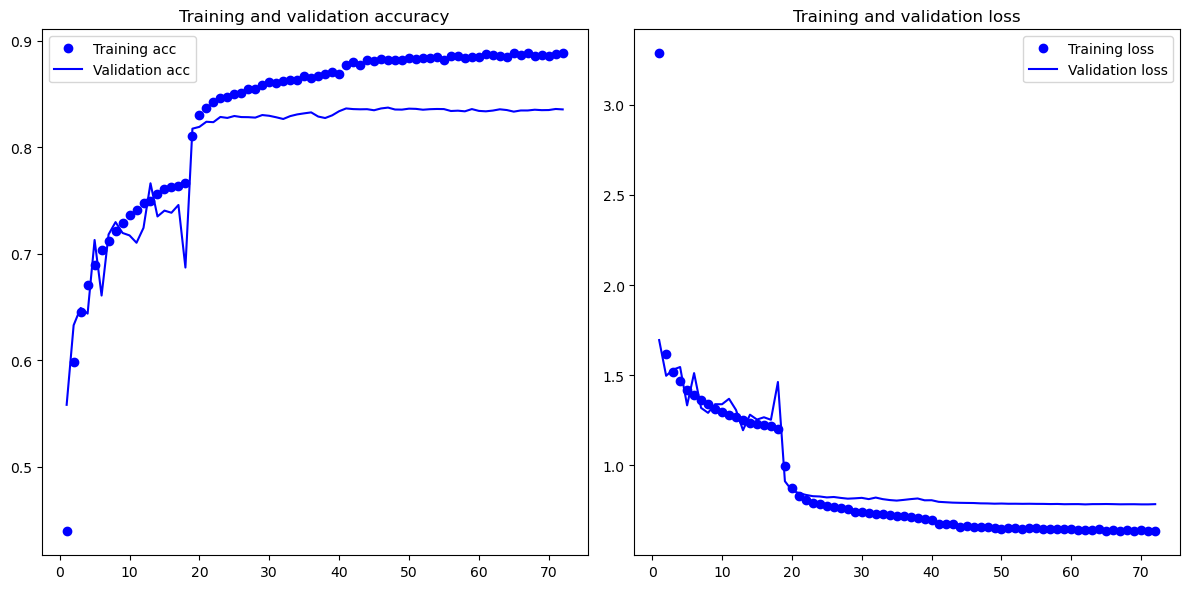

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

> We see that the model is overfitting after 10 epochs.  
> The validation accuracy stops improving significantly after the 10th epoch while the training accuracy keeps improving.  
> The validation loss stops improving significantly after the 13th epoch while the training loss keeps improving.  
> However, the best model is saved on the 40th epoch.

---
#### Model Testing

In [14]:
test_labels = []
test_predictions = []

for images, labels in test_dataset:
    test_labels.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions.extend(np.argmax(predictions, axis=-1))

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)

1/1 [==============================] - 0s 72ms/step


---
#### Confusion Matrix

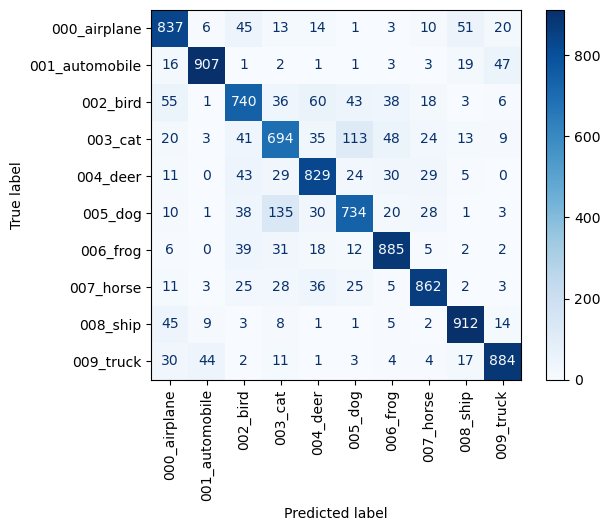

In [15]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

> Looking at the confusion matrix, we see that the model has some trouble distinguishing between some categories.  
> The model has a hard time distinguishing between the categories 003_cat and 005_dog.  
> The model also has a hard time distinguishing between some other categories but the error is not as significant.  
> The model has an acceptable performance on the categories 001_automobile, 002_airplane, 006_frog, 007_horse, 008_ship and 009_truck.  
> However, the model improved from the previous one.

---
#### Performance Metrics

In [16]:
acc = accuracy_score(y_true =  test_labels, y_pred = test_predictions)
print(f'Accuracy : {np.round(acc*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')
precision = precision_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')
recall = recall_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')
f1 = f1_score(y_true =  test_labels, y_pred = test_predictions, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 82.84%
Precision - Macro: 82.81%
Recall - Macro: 82.84%
F1-score - Macro: 82.81%
Precision - Weighted: 82.81%
Recall - Weighted: 82.84%
F1-score - Weighted: 82.81%


> Accuracy is the proportion of correctly predicted instances out of the total instances.  
> Precision is the ratio of true positive predictions to the total predicted positives. Macro precision calculates this for each class independently and then averages them.  
> Weighted precision calculates the precision for each class, then averages them, weighted by the number of true instances for each class.  
> Recall is the ratio of true positive predictions to the total actual positives. Macro recall calculates this for each class independently and then averages them.  
> Weighted recall calculates the recall for each class, then averages them, weighted by the number of true instances for each class.  
> The F1-score is the harmonic mean of precision and recall. Macro F1-score calculates this for each class independently and then averages them.  
> Weighted F1-score calculates the F1-score for each class, then averages them, weighted by the number of true instances for each class.

# Conclusion
> We have trained a model with a data augmentation pipeline, dropout and Adam optimizer.  
> We opted for a simple data augmentation technique of horizontal flipping.  
> We have created a model with a more complex architecture than the previous one.  
> We added a 128 convolutional layer and increased the 256 dense layer.  
> We added L2 regularization to the newly added convolutional layer and modified dense layer.  
> We kept the rest of the model the same.  
> The model has shown some trouble distinguishing between some categories.  
> The model started overfitting after 16 epochs but the best model was saved on the 37th epoch.  
> The model has shown an accuracy of 81.28% on the test set.  
> The model has shown a good performance on the test set with a macro F1-score of 81.23% and a weighted F1-score of 81.23%.  
> The model has shown a good performance on the test set with a macro precision of 81.21% and a weighted precision of 81.21%.  
> The model has shown a good performance on the test set with a macro recall of 81.28% and a weighted recall of 81.28%.  
> The model has shown a performance improvement from the previous one.  
> TODO: Report